In [1]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import io
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import tqdm, trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose, walking_pose

from flygym.arena.mujoco_arena import MixedTerrain, BlocksTerrain, GappedTerrain, FlatTerrain, Tethered

from flygym.util.cpg_controller import (
    advancement_transfer,
    phase_oscillator,
    initialize_solver,
    phase_biases_tripod_idealized,
    plot_phase_amp_output,
    sine_output,
)

from tqdm import trange
import cv2

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

In [3]:
cs_placements = all_tarsi_links = [
    f"{side}{pos}Tarsus{i}" for side in "LR" for pos in "FMH" for i in range(1, 6)
]
cs_placements += [f"{side}{pos}Tibia" for side in "LR" for pos in "FMH"]

sim_params = MuJoCoParameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.1,
    render_camera="Animat/camera_right_top_zoomout",
    render_window_size=(700, 560),
    enable_adhesion=True,
    draw_adhesion=True,
    draw_contacts=False,
    adhesion_gain=20,
    actuator_kp=30,
    adhesion_off_duration=0.03,
)

In [4]:
run_time = 1

arena = FlatTerrain()
arena = BlocksTerrain()
# arena = GappedTerrain(gap_width=0.2)
# arena = MixedTerrain()

spawn0 = [0.0, 0.0, 0.5]

spawn1 = [2.3, 0.2, 0.5]
spawn2 = [0.0, 0.2, 0.5]
spawn3 = [0.8, -0.9, 0.5]
sim_params.render_playspeed = 0.1
sim_params.render_camera = "Animat/camera_right_top_zoomout"
sim_params.adhesion_gain = 40.0
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    arena=arena,
    spawn_pos=spawn1,
    contact_sensor_placements=np.array(cs_placements),
)
num_steps_base = int(run_time / nmf.timestep)

In [5]:
obs, info = nmf.reset()
base_angles = obs["joints"][0]

joint_angles_modif = []
obs_list = []

joint_angles = base_angles.copy()

legs = [lts[:2] for lts in nmf.last_tarsalseg_names]
joints_in_leg = [[i for i, joint in enumerate(
    nmf.actuated_joints) if leg in joint] for leg in legs]
joint_name_to_id = {joint[8:]: i for i, joint in enumerate(
    nmf.actuated_joints[:len(joints_in_leg[0])])}

raise_leg = np.zeros((len(legs), 42))
for i, leg in enumerate(legs):
    if "F" in leg:
        raise_leg[i, joints_in_leg[i][joint_name_to_id["Femur"]]] = -0.02
        raise_leg[i, joints_in_leg[i][joint_name_to_id["Tibia"]]] = +0.016
    elif "M" in leg:
        raise_leg[i, joints_in_leg[i][joint_name_to_id["Coxa"]]] = -0.015
        raise_leg[i, joints_in_leg[i][joint_name_to_id["Femur"]]] = 0.004
        raise_leg[i, joints_in_leg[i][joint_name_to_id["Tibia"]]] = 0.01
        raise_leg[i, joints_in_leg[i][joint_name_to_id["Tarsus1"]]] = -0.008
        raise_leg[i, joints_in_leg[i]] *= 1.2
    elif "H" in leg:
        raise_leg[i, joints_in_leg[i][joint_name_to_id["Femur"]]] = -0.01
        raise_leg[i, joints_in_leg[i][joint_name_to_id["Tibia"]]] = +0.005

In [6]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

In [7]:
# Interpolate 5x
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(
    step_duration * data['meta']['timestep'] / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])


In [8]:
LEGS = ["LF", "LM", "LH", "RF", "RM", "RH"]

leg_ids = np.arange(len(LEGS)).astype(int)
leg_corresp_id = dict(zip(LEGS, leg_ids))
n_joints = len(nmf.actuated_joints)
joint_ids = np.arange(n_joints).astype(int)
match_leg_to_joints = np.array(
    [
        i
        for joint in nmf.actuated_joints
        for i, leg in enumerate(LEGS)
        if leg in joint
    ]
)


In [9]:
###########  CONSTANTS ############
CONTROLLER_SEED = 42
STABILIZATION_DUR = 0.2
N_OSCILLATORS = len(LEGS)

COUPLING_STRENGTH = 10.0
AMP_RATES = 20.0
TARGET_AMPLITUDE = 1.0

n_stabilization_steps = int(STABILIZATION_DUR/nmf.timestep)

frequencies = np.ones(N_OSCILLATORS) * 10

# For now each oscillator have the same amplitude
target_amplitudes = np.ones(N_OSCILLATORS) * TARGET_AMPLITUDE
rates = np.ones(N_OSCILLATORS) * AMP_RATES

phase_biases = phase_biases_tripod_idealized * 2 * np.pi
coupling_weights = (np.abs(phase_biases) > 0).astype(float) * COUPLING_STRENGTH


In [10]:
num_steps = n_stabilization_steps + num_steps_base

# Initilize the simulation
np.random.seed(CONTROLLER_SEED)
start_ampl = np.ones(6) * 0.2

obs, _ = nmf.reset()

solver = initialize_solver(
    phase_oscillator,
    "dopri5",
    nmf.curr_time,
    N_OSCILLATORS,
    frequencies,
    coupling_weights,
    phase_biases,
    start_ampl,
    rates,
    int_params={"atol": 1e-6, "rtol": 1e-6, "max_step": 100000},
)
all_adhesions = []

joint_angles = np.zeros((num_steps, len(nmf.actuated_joints)))
adhesion_signal = np.zeros(6)
# Initalize storage
obs_list = []
phases = np.zeros((num_steps, N_OSCILLATORS))
amplitudes = np.zeros((num_steps, N_OSCILLATORS))

all_indices = []
time = []

legs_in_hole = [False]*6
deepest_leg_in_hole = [False]*6
legs_in_hole_increment = np.zeros(6)

# detect leg with "unatural" other than tarsus 4 or 5 contacts
leg_tarsus12T_contactsensors = [[i for i, cs in enumerate(nmf.contact_sensor_placements)
                                 if tarsal_seg[:2] in cs and ("Tibia" in cs or "Tarsus1" in cs)]
                                for tarsal_seg in nmf.last_tarsalseg_names]
force_threshold = -1.0
highest_proximal_contact_leg = [False]*6
legs_w_proximalcontact_increment = np.zeros(6)

increase_rate_stumble = 0.1
decrease_rate_stumble = 0.07

increase_rate_hole = 0.01
decrease_rate_hole = 0.009

legs_in_hole_increments = []
legs_w_proximalcontact_increments = []

joint_angle_increments = []

last_tarsalseg_to_adh_id = [i for adh in nmf.adhesion_actuators for i, lts in enumerate(
    nmf.last_tarsalseg_names) if lts[:2] == adh.name[:2]]

med_values = []

joint_angles_list = []

for i in trange(num_steps):
    if i > n_stabilization_steps:
        # detect leg in gap show as blue tibia #only keep the deepest leg in the hole
        ee_z_pos = obs["end_effectors"][2::3]
        leg_to_thorax_zdistance = obs["fly"][0][2] - ee_z_pos
        legs_in_hole = leg_to_thorax_zdistance > np.median(
            leg_to_thorax_zdistance)+0.1
        med_values.append(np.median(leg_to_thorax_zdistance))
        legs_in_hole = np.logical_and(
            legs_in_hole, leg_to_thorax_zdistance == np.max(leg_to_thorax_zdistance))
        # legs_in_hole = np.zeros(6, dtype=bool)
        for k, tarsal_seg in enumerate(nmf.last_tarsalseg_names):
            if legs_in_hole[k]:
                nmf.physics.named.model.geom_rgba["Animat/" +
                                                  tarsal_seg[:2]+"Tibia_visual"] = [0.0, 0.0, 1.0, 1.0]
                legs_in_hole_increment[k] += increase_rate_hole
            else:
                nmf.physics.named.model.geom_rgba["Animat/" +
                                                  tarsal_seg[:2]+"Tibia_visual"] = nmf.base_rgba
                if legs_in_hole_increment[k] > 0:
                    legs_in_hole_increment[k] -= decrease_rate_hole

        # detect leg with "unatural" other than tarsus 2, 3, 4 or 5 contacts and show as red Femur (Only look at force along negative x)
        tarsus12T_contact_force = np.min(
            obs["contact_forces"][0, leg_tarsus12T_contactsensors], axis=1)
        # look for the highest force
        highest_proximal_contact_leg = np.logical_and(
            tarsus12T_contact_force < force_threshold,
            min(tarsus12T_contact_force) == tarsus12T_contact_force
        )
        for k, tarsal_seg in enumerate(nmf.last_tarsalseg_names):
            if highest_proximal_contact_leg[k] and not legs_in_hole[k]:
                nmf.physics.named.model.geom_rgba["Animat/" +
                                                  tarsal_seg[:2]+"Femur_visual"] = [1.0, 0.0, 0.0, 1.0]
                legs_w_proximalcontact_increment[k] += increase_rate_stumble
            else:
                nmf.physics.named.model.geom_rgba["Animat/" +
                                                  tarsal_seg[:2]+"Femur_visual"] = nmf.base_rgba
                if legs_w_proximalcontact_increment[k] > 0:
                    legs_w_proximalcontact_increment[k] -= decrease_rate_stumble

    joint_angle_increment = (raise_leg.T*legs_in_hole_increment).sum(
        axis=1) + (raise_leg.T*legs_w_proximalcontact_increment).sum(axis=1)
    joint_angle_increments.append(joint_angle_increment.copy())

    legs_in_hole_increments.append(legs_in_hole_increment.copy())
    legs_w_proximalcontact_increments.append(
        legs_w_proximalcontact_increment.copy())

    # Only step the solver if there is no need for paralysis
    # if the leg is stuck: leg_tarsus12T_accumulator > accumulator_threshold
    # All other legs are kept paralyzed phase is constant
    # The stuck leg increases its phase by 2*np.pi/interp_step_duration (should be two steps)
    res = solver.integrate(nmf.curr_time)
    phase = res[:N_OSCILLATORS]
    amp = res[N_OSCILLATORS: 2 * N_OSCILLATORS]

    phases[i, :] = phase
    amplitudes[i, :] = amp

    if i == n_stabilization_steps:
        # Now set the amplitude to their real values
        solver.set_f_params(
            N_OSCILLATORS,
            frequencies,
            coupling_weights,
            phase_biases,
            target_amplitudes,
            rates,
        )
    if i > n_stabilization_steps:
        indices = advancement_transfer(
            phase, interp_step_duration, match_leg_to_joints
        )
        all_indices.append(indices)

        # scale amplitude by interpolating between the resting values and i timestep value
        input_joint_angles = (
            data_block[joint_ids, 0]
            + (data_block[joint_ids, indices] - data_block[joint_ids, 0])
            * amp[match_leg_to_joints]
        )
    else:
        input_joint_angles = data_block[joint_ids, 0]

    input_joint_angles = input_joint_angles + joint_angle_increment
    joint_angles[i, :] = input_joint_angles
    adhesion_signal = nmf.get_adhesion_vector()
    adhesion_signal[np.logical_or(legs_in_hole, highest_proximal_contact_leg)[
        last_tarsalseg_to_adh_id]] = 0.0
    all_adhesions.append(adhesion_signal)

    joint_angles_list.append(input_joint_angles)

    action = {"joints": input_joint_angles, "adhesion": adhesion_signal}

    obs, _, _, _, _ = nmf.step(action)
    obs_list.append(obs)
    render_status = nmf.render()

    time.append(nmf.curr_time)

  0%|          | 0/12000 [00:00<?, ?it/s]

100%|██████████| 12000/12000 [00:39<00:00, 307.39it/s]


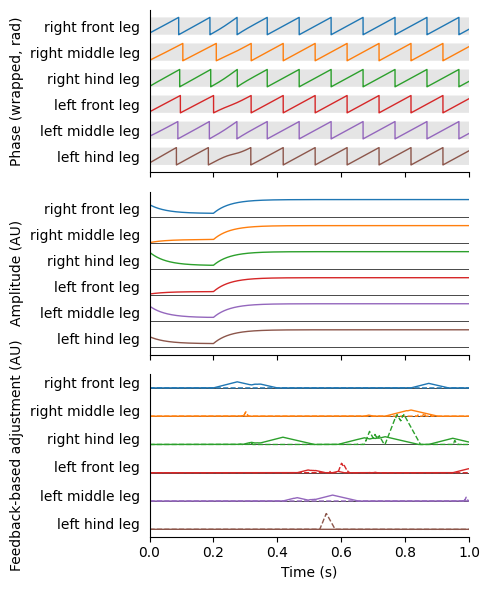

In [25]:
timestep = nmf.timestep
labels = legs
rule_labels = ["Retraction", "Stumbling"]
leg_basey_lookup = {
    "right front leg": 0,
    "right middle leg": -1,
    "right hind leg": -2,
    "left front leg": -3,
    "left middle leg": -4,
    "left hind leg": -5,
}
leg_name_lookup = {
    "RF": "right front leg",
    "LF": "left front leg",
    "RM": "right middle leg",
    "LM": "left middle leg",
    "RH": "right hind leg",
    "LH": "left hind leg",
}
color_lookup = {
    "RF": "C0",
    "RM": "C1",
    "RH": "C2",
    "LF": "C3",
    "LM": "C4",
    "LH": "C5",
}

# rules = [legs_in_hole_increments, legs_w_proximalcontact_increments]
legs_in_hole_increments = np.array(legs_in_hole_increments)
legs_w_proximalcontact_increments = np.array(legs_w_proximalcontact_increments)

time = timestep * np.arange(len(phases))


def plot_frame(current_time=None, video_layout=False):
    if video_layout:
        fig, axs = plt.subplots(2, 2, figsize=(10, 4), tight_layout=True)
    else:
        fig, axs = plt.subplots(3, 1, sharex=True, figsize=(5, 6), tight_layout=True)

    # phase plot
    ax = axs.flatten()[0]
    for i, leg_code in enumerate(legs):
        leg_name = leg_name_lookup[leg_code]
        phase_ts = np.mod(phases[:, i], np.pi * 2)
        ax.plot(
            time,
            phase_ts + leg_basey_lookup[leg_name] * np.pi * 3 - np.pi,
            color=color_lookup[leg_code],
            linewidth=1,
        )
        if current_time is not None:
            ax.axvline(current_time, color="red", linewidth=2, zorder=100)
        ax.fill_between(
            time,
            leg_basey_lookup[leg_name] * np.pi * 3 - np.pi,
            leg_basey_lookup[leg_name] * np.pi * 3 + np.pi,
            facecolor="gray",
            edgecolor="none",
            alpha=0.2,
            zorder=-1,
            linewidth=1,
        )
    if video_layout:
        ax.set_xlabel("Time (s)")
    ax.set_yticks(np.array(list(leg_basey_lookup.values())) * np.pi * 3)
    ax.set_yticklabels(list(leg_basey_lookup.keys()))
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    ax.set_ylabel("Phase (wrapped, rad)")

    # amplitude plot
    ax = axs.flatten()[1]
    for i, leg_code in enumerate(legs):
        leg_name = leg_name_lookup[leg_code]
        amp_ts = amplitudes[:, i]
        ax.plot(
            time,
            amp_ts + leg_basey_lookup[leg_name] * 1.5 - 0.5,
            color=color_lookup[leg_code],
            linewidth=1,
        )
        if current_time is not None:
            ax.axvline(current_time, color="red", linewidth=2, zorder=100)
        ax.axhline(
            leg_basey_lookup[leg_name] * 1.5 - 0.5,
            color="k",
            linestyle="-",
            linewidth=0.5,
            zorder=-1,
        )
    if video_layout:
        ax.set_yticks([])
        ax.set_yticklabels([])
    else:
        ax.set_yticks(np.array(list(leg_basey_lookup.values())) * 1.5)
        ax.set_yticklabels(list(leg_basey_lookup.keys()))
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    ax.set_ylabel("Amplitude (AU)")
    if video_layout:
        ax.set_xlabel("Time (s)")

    # rule plot
    ax = axs.flatten()[2]
    for i, leg_code in enumerate(legs):
        leg_name = leg_name_lookup[leg_code]
        retraction_ts = legs_in_hole_increments[:, i]
        stumbling_ts = legs_w_proximalcontact_increments[:, i]
        ax.plot(
            time,
            retraction_ts + leg_basey_lookup[leg_name] * 34 - 17,
            linestyle="-",
            color=color_lookup[leg_code],
            linewidth=1,
        )
        ax.plot(
            time,
            stumbling_ts + leg_basey_lookup[leg_name] * 34 - 17,
            linestyle="--",
            color=color_lookup[leg_code],
            linewidth=1,
        )
        if current_time is not None:
            ax.axvline(current_time, color="red", linewidth=2, zorder=100)
        ax.axhline(
            leg_basey_lookup[leg_name] * 34 - 17,
            color="k",
            linestyle="-",
            linewidth=0.5,
            zorder=-1,
        )
    ax.set_yticks(np.array(list(leg_basey_lookup.values())) * 34 - 10)
    ax.set_yticklabels(list(leg_basey_lookup.keys()))
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    if video_layout:
        ax.set_ylabel("Feedback-based\nadjustment (AU)")
    else:
        ax.set_ylabel("Feedback-based adjustment (AU)")
    ax.set_xlabel("Time (s)")

    if video_layout:
        axs.flatten()[3].axis("off")

    sns.despine()
    return fig

plt.style.use("default")
fig = plot_frame()
fig.savefig("outputs/hybrid.pdf", transparent=True)

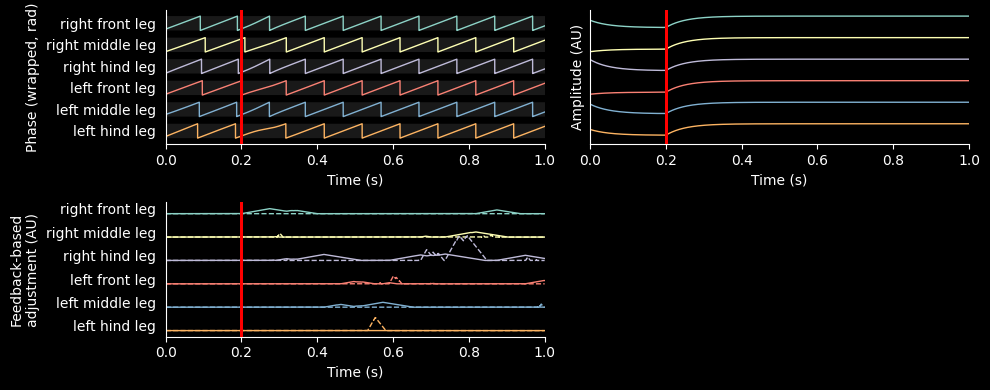

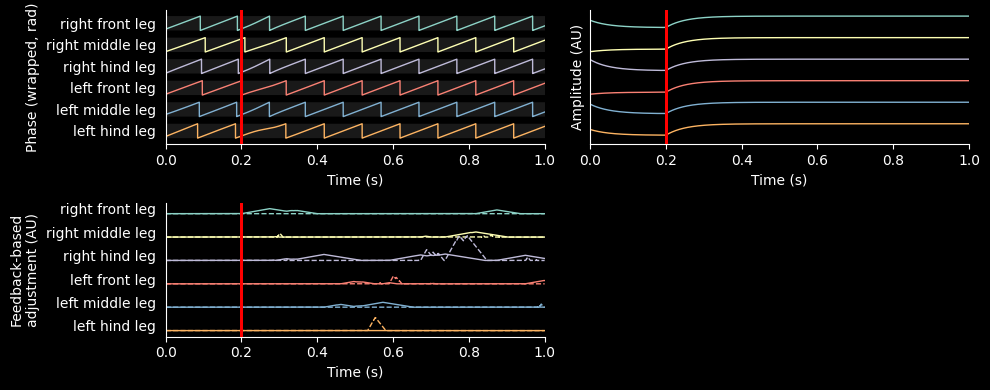

In [26]:
plt.style.use("dark_background")
plot_frame(current_time=0.2, video_layout=True)

In [27]:
def matplotlib_figure_to_array(fig):
    """Adapted from https://stackoverflow.com/a/67823421/13560623"""
    with io.BytesIO() as buff:
        fig.savefig(buff, format='raw')
        buff.seek(0)
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    return data.reshape((int(h), int(w), -1))

In [28]:
def merge_frame_and_time_series(i, frame):
    current_time = i * nmf._eff_render_interval
    time_series_fig = plot_frame(current_time, video_layout=True)
    time_series_img = matplotlib_figure_to_array(time_series_fig)
    plt.close(fig=time_series_fig)
    assert frame.shape[0] >= time_series_img.shape[0]
    # height = time_series_img.shape[0]
    # frame_width = int(height * frame.shape[1] / frame.shape[0])
    # frame = cv2.resize(frame, (frame_width, height))
    # merged_frame = np.concatenate([frame, time_series_img[:, :, :3]], axis=1)
    width = frame.shape[1]
    ts_height = int(width * time_series_img.shape[0] / time_series_img.shape[1])
    time_series_img = cv2.resize(time_series_img, (width, ts_height))
    merged_frame = np.concatenate([frame[:, :, :3], time_series_img[:, :, :3]], axis=0)
    return merged_frame

In [29]:
len(nmf._frames)

720

In [30]:
#n_frames_to_drop = int(n_stabilization_steps * nmf.timestep / nmf._eff_render_interval)
frames_to_render = nmf._frames#[n_frames_to_drop:]
video_shape = merge_frame_and_time_series(0, frames_to_render[0]).shape

out = cv2.VideoWriter(
    "outputs/hybrid.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    sim_params.render_fps,
    (video_shape[1], video_shape[0]),
)

for i, frame in tqdm(enumerate(frames_to_render), total=len(frames_to_render)):
    merged_frame = merge_frame_and_time_series(i, frame)
    out.write(merged_frame[:, :, ::-1])  # RGB to BGR
out.release()

100%|██████████| 720/720 [02:00<00:00,  5.98it/s]


: 